In [2]:
# 不同数据集大概被生成了多少数据？
# 每个场景的平均人数，最少人数，最多人数
# 如果是在世界坐标系的话，xmin xmax ymin ymax 都是多少
# 行人平均速度

In [58]:
import numpy as np
from src.utils import *
from tqdm import tqdm
import matplotlib.pyplot as plt

torch.manual_seed(0)
np.random.seed(0)
random.seed(0)


In [29]:
# DATASET_NAME_TO_NUM = {
#     'eth': 0,
#     'hotel': 1,
#     'zara1': 2,
#     'zara2': 3,
#     'univ': 4
# }


dataloader = {}
for dataset in ["eth", "hotel", "zara1", "zara2", "univ"]:
    class Config:
        def __init__(self, dictionary):
            for key, value in dictionary.items():
                setattr(self, key, value)


    args_dict = {
        "batch_around_ped": 256,
        "batch_size": 8,
        "clip": 1,
        "config": f"testtest/{dataset}/star/config_train.yaml",
        "dataset": "eth5",
        "determine": 1,
        "early_stop": 1,
        "emb": 128,
        "learning_rate": 0.001,
        "load_model_id": None,
        "model_dir": f"testtest/{dataset}/star/",
        "modelname": "star",
        "num_epochs": 100,
        "obs_length": 8,
        "patience": 20,
        "phase": "train",
        "randomRotate": True,
        "sample_num": 20,
        "save_base_dir": "testtest",
        "save_dir": f"testtest/{dataset}/",
        "scheduler_method": "Cosine",
        "sendwx": True,
        "seq_length": 20,
        "test_set": dataset,
        "using_cuda": True
    }

    args = Config(args_dict)
    if not os.path.exists(args.model_dir):
        os.makedirs(args.model_dir)

    dataloader[dataset] = Trajectory_Dataloader(args)

Creating pre-processed data from raw data.
0 389
100 389
200 389
300 389
0 148
100 148
0 204
100 204
200 204
0 415
100 415
200 415
300 415
400 415
0 434
100 434
200 434
300 434
400 434
0 118
100 118
0 137
100 137
0 360
100 360
200 360
300 360
Done.
Preparing data batches.
0 / 5520
100 / 5520
200 / 5520
300 / 5520
400 / 5520
500 / 5520
600 / 5520
700 / 5520
800 / 5520
900 / 5520
1000 / 5520
1100 / 5520
1200 / 5520
1300 / 5520
1400 / 5520
1500 / 5520
1600 / 5520
1700 / 5520
1800 / 5520
1900 / 5520
2000 / 5520
2100 / 5520
2200 / 5520
2300 / 5520
2400 / 5520
2500 / 5520
2600 / 5520
2700 / 5520
2800 / 5520
2900 / 5520
3000 / 5520
3100 / 5520
3200 / 5520
3300 / 5520
3400 / 5520
3500 / 5520
3600 / 5520
3700 / 5520
3800 / 5520
3900 / 5520
4000 / 5520
4100 / 5520
4200 / 5520
4300 / 5520
4400 / 5520
4500 / 5520
4600 / 5520
4700 / 5520
4800 / 5520
4900 / 5520
5000 / 5520
5100 / 5520
5200 / 5520
5300 / 5520
5400 / 5520
5500 / 5520
0 / 1444
100 / 1444
200 / 1444
300 / 1444
400 / 1444
500 / 1444
600

In [34]:
for dataset in ["eth", "hotel", "zara1", "zara2", "univ"]:
    cnt = 0
    dataloader[dataset].reset_batch_pointer(set='test')
    for batch in range(dataloader[dataset].testbatchnums):
        cnt += 1
    print(dataset, " test ", cnt)
    cnt = 0
    dataloader[dataset].reset_batch_pointer(set='train', valid=False)
    for batch in range(dataloader[dataset].trainbatchnums):
        cnt += 1
    print(dataset, " train ", cnt)
    print("  ")

eth  test  25
eth  train  224
  
hotel  test  11
hotel  train  238
  
zara1  test  18
zara1  train  230
  
zara2  test  37
zara2  train  212
  
univ  test  138
univ  train  112
  


In [53]:
pedcont = {}


for dataset in ["eth", "hotel", "zara1", "zara2", "univ"]:
    cnt = 0
    dataloader[dataset].reset_batch_pointer(set='test')
    pedcont[dataset] = []
    for batch in range(dataloader[dataset].testbatchnums):
        inputs_ori, batch_id = dataloader[dataset].get_test_batch(batch)

        inputs = []
        for idx, contents in enumerate(inputs_ori):
            inputs.append(contents)

        batch_abs, batch_norm, shift_value, seq_list, scenes, batch_pednum = inputs
        inputs_forward = batch_abs[:-1], batch_norm[:-1], shift_value[:-1], seq_list[:-1], scenes, batch_pednum
        
        pedcont[dataset] += batch_pednum

    print(dataset,"   ", min(pedcont[dataset]),"   ", np.mean(pedcont[dataset]),"   ", max(pedcont[dataset]))


eth     1     7.186946902654867     26
hotel     1     6.585956416464891     17
zara1     2     6.353191489361702     20
zara2     1     9.504008016032063     20
univ     14     40.205913410770854     75


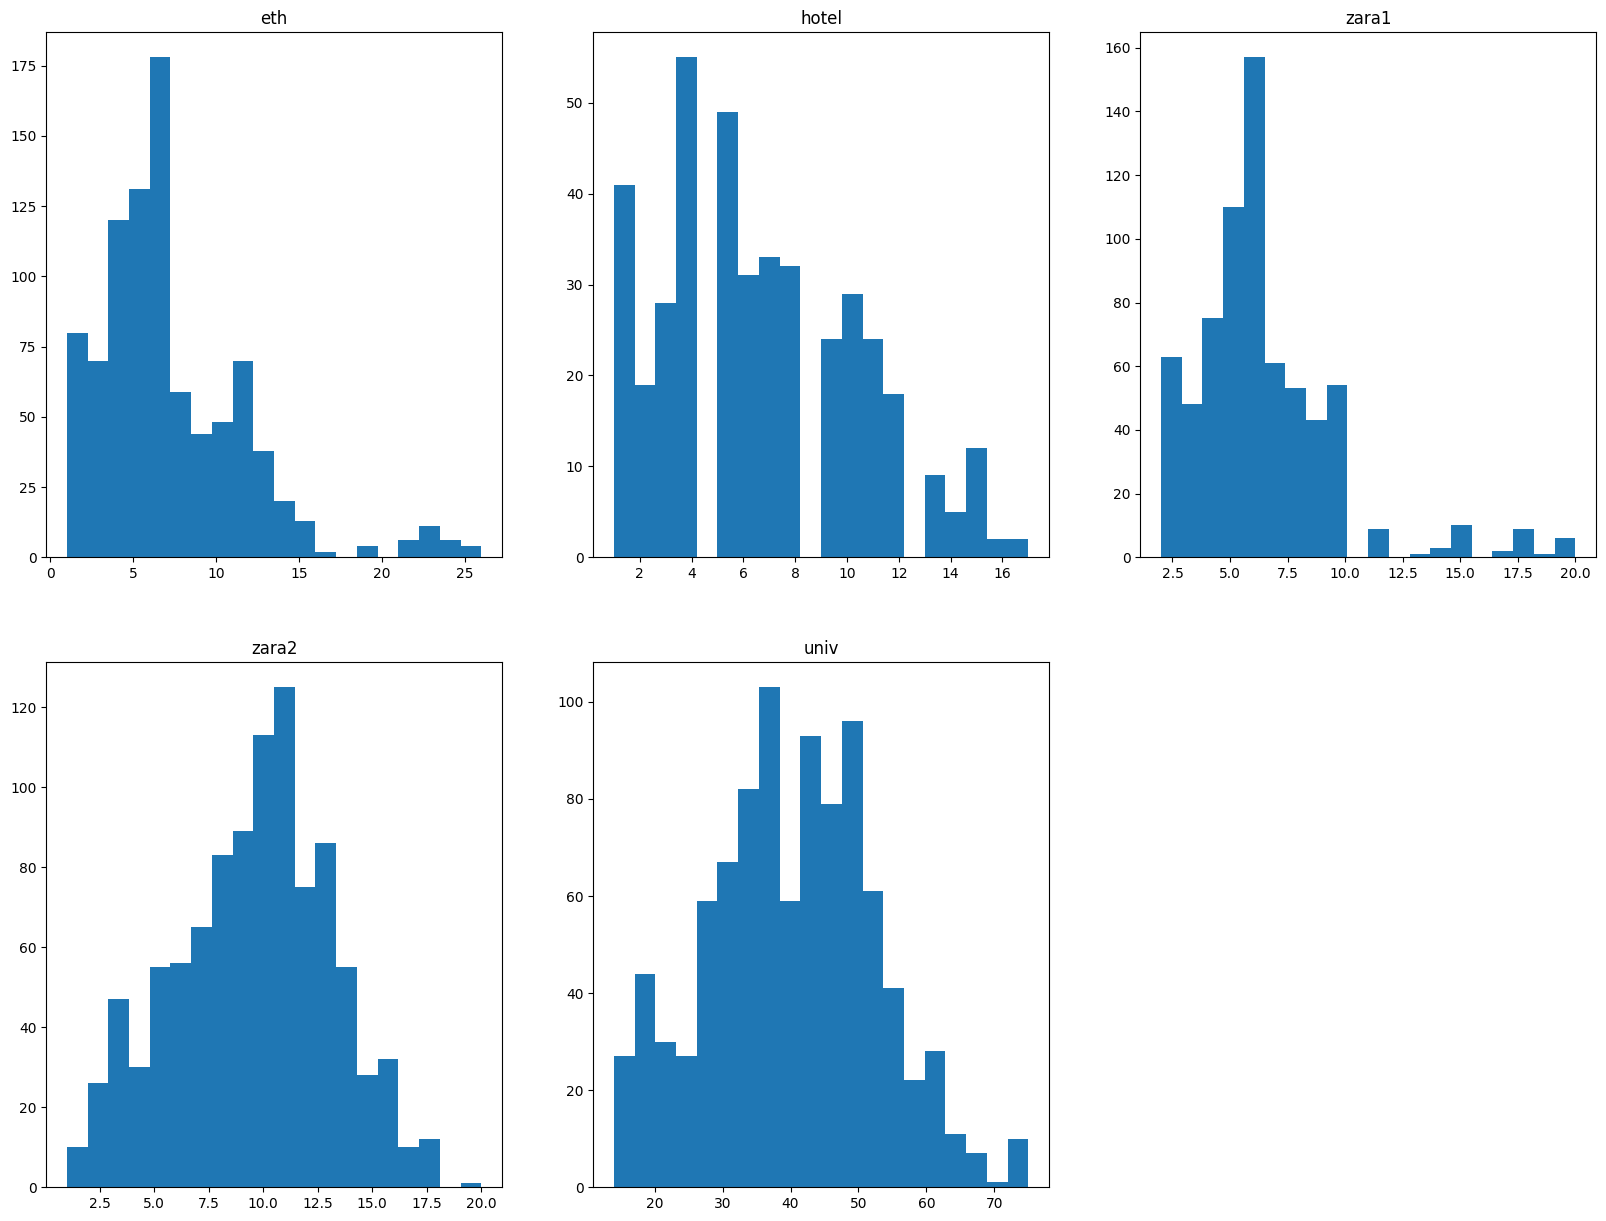

In [83]:


plt.figure(figsize=[20,15])
for idx, dataset in enumerate(["eth", "hotel", "zara1", "zara2", "univ"]):
    plt.subplot(2, 3, idx+1)
    plt.hist(pedcont[dataset],bins=20)
    plt.title(dataset)
plt.show()

In [78]:

def compute_step_lengths(trajectories):
    # 计算每个行人在相邻两帧之间的坐标差
    diffs = np.diff(trajectories, axis=0)
    
    # 计算欧几里得距离，即每步的长度
    step_lengths = np.linalg.norm(diffs, axis=2)
    
    # 将结果转换为一维列表
    step_lengths_list = step_lengths.flatten()
    
    return step_lengths_list

speed = {}

for dataset in ["eth", "hotel", "zara1", "zara2", "univ"]:
    cnt = 0
    dataloader[dataset].reset_batch_pointer(set='test')
    speed[dataset] = []
    for batch in range(dataloader[dataset].testbatchnums):
        inputs_ori, batch_id = dataloader[dataset].get_test_batch(batch)

        inputs = []
        for idx, contents in enumerate(inputs_ori):
            inputs.append(contents)

        batch_abs, batch_norm, shift_value, seq_list, scenes, batch_pednum = inputs
        inputs_forward = batch_abs[:-1], batch_norm[:-1], shift_value[:-1], seq_list[:-1], scenes, batch_pednum
        step_lengths = compute_step_lengths(inputs_forward[0])
        speed[dataset] += [i for i in step_lengths.tolist() if i<2]
        

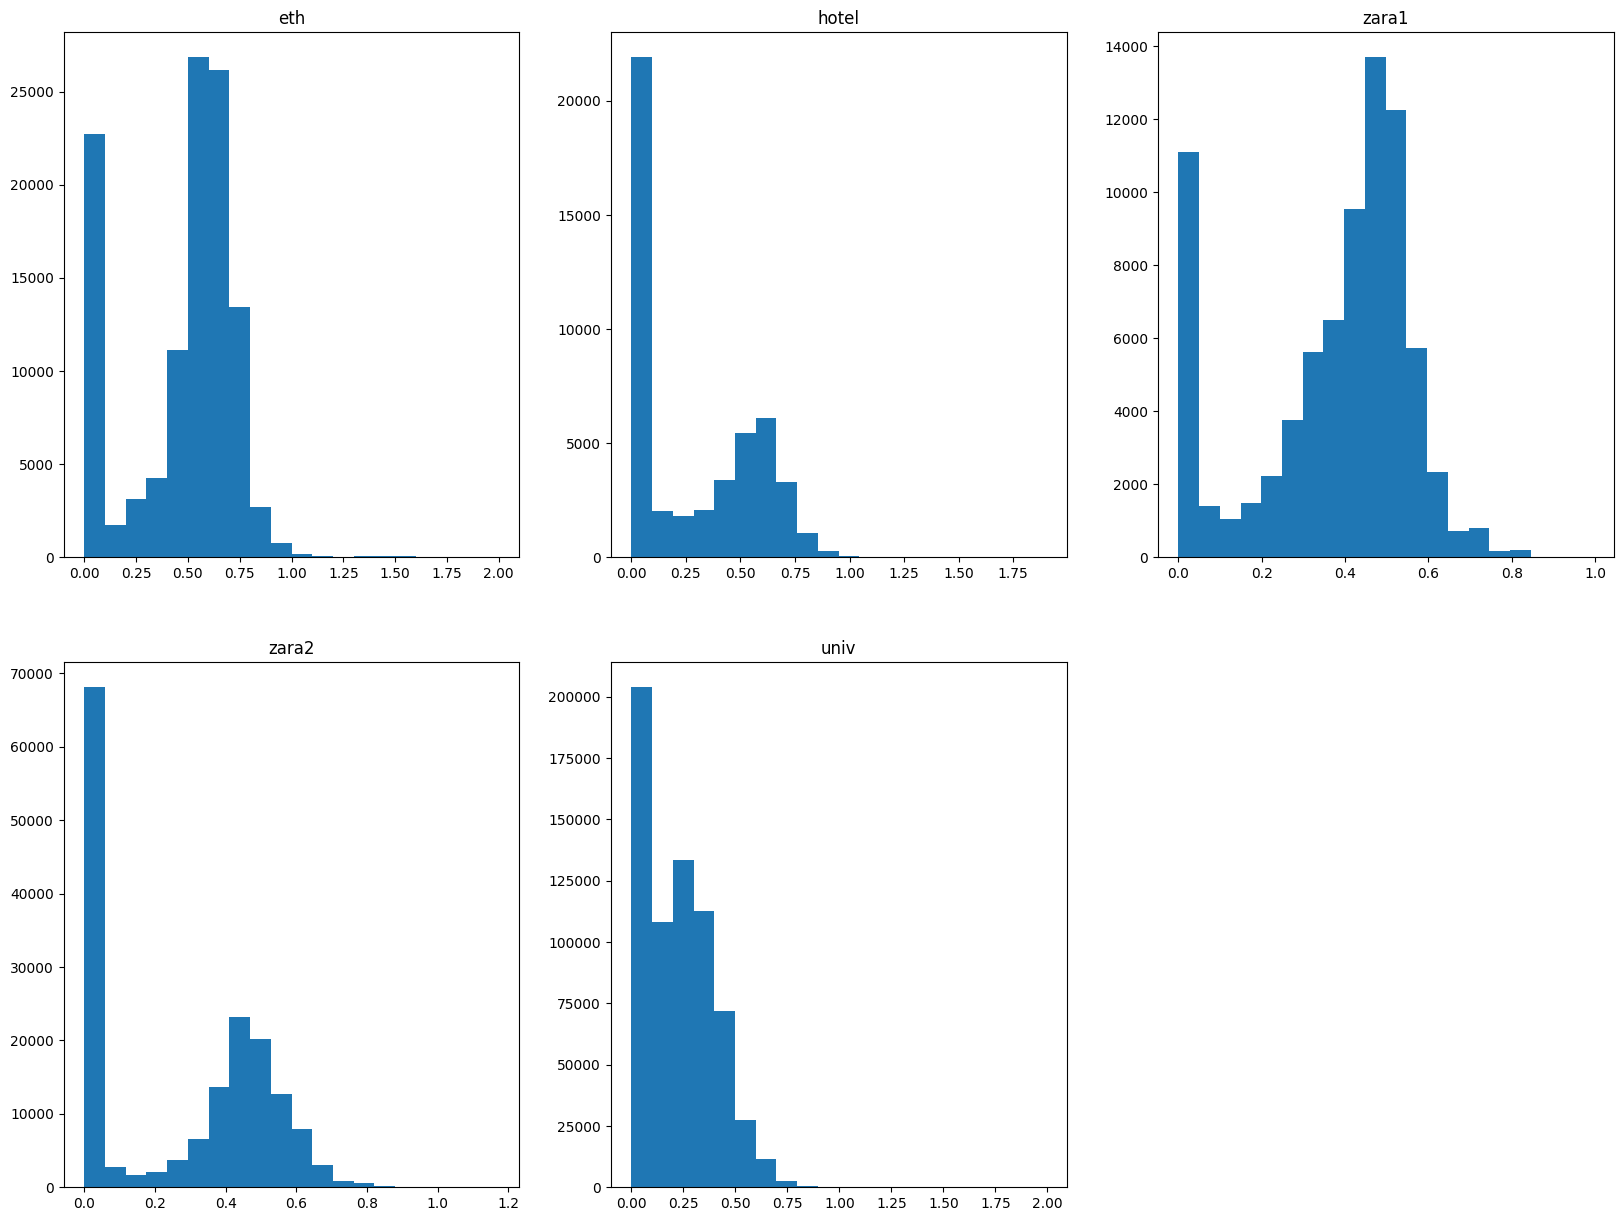

In [82]:
plt.figure(figsize=[20,15])
for idx, dataset in enumerate(["eth", "hotel", "zara1", "zara2", "univ"]):
    plt.subplot(2, 3, idx+1)
    plt.hist(speed[dataset],bins=20)
    plt.title(dataset)
plt.show()

In [ ]:
class processor(object):
    def __init__(self, args, model_parameters):
        # initialization
        self.args = args
        self.model_parameters = model_parameters
        self.dataloader = Trajectory_Dataloader(args)



    def train_epoch(self, epoch):

        self.dataloader.reset_batch_pointer(set='train', valid=False)
        loss_epoch = 0
        # 初始化进度条
        pbar = tqdm(total=self.dataloader.trainbatchnums, leave=False, ncols=80)

        for batch in range(self.dataloader.trainbatchnums):
            # self.optimizer.zero_grad()
            # start = time.time()
            inputs_ori, batch_id = self.dataloader.get_train_batch(batch)
            inputs = []
            for idx, contents in enumerate(inputs_ori):
                if idx != len(inputs_ori) - 2:
                    contents = torch.Tensor(contents).cuda()
                inputs.append(contents)
            # inputs = tuple([torch.Tensor(i) for i in inputs])
            # inputs = tuple([i.cuda() for i in inputs])
            loss = torch.zeros(1).cuda()
            batch_abs, batch_norm, shift_value, seq_list, scenes, batch_pednum = inputs
            inputs_forward = batch_abs[:-1], batch_norm[:-1], shift_value[:-1], seq_list[:-1], scenes, batch_pednum



    @torch.no_grad()
    def test_epoch(self):
        self.dataloader.reset_batch_pointer(set='test')
        error_epoch, final_error_epoch = 0, 0,
        error_cnt_epoch, final_error_cnt_epoch = 1e-5, 1e-5

        for batch in range(self.dataloader.testbatchnums):

            inputs_ori, batch_id = self.dataloader.get_test_batch(batch)
            inputs = []
            for idx, contents in enumerate(inputs_ori):
                if idx != len(inputs_ori) - 2:
                    contents = torch.Tensor(contents)
                    if self.args.using_cuda:
                        contents = contents.cuda()
                inputs.append(contents)

            batch_abs, batch_norm, shift_value, seq_list, scenes, batch_pednum = inputs

            inputs_forward = batch_abs[:-1], batch_norm[:-1], shift_value[:-1], seq_list[:-1], scenes, batch_pednum

        